In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
folder = '/Users/julianganzabal/.kaggle/competitions/fashion-mnist-itba-lab-ml/'

In [3]:
x = np.load(folder+'train_images.npy')
y = np.loadtxt(folder+'train_labels.csv', delimiter=',', skiprows=1)

In [4]:
x_test = np.load(folder+'test_images.npy')

In [5]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.1)

In [6]:
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint 
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras import initializers
from fnn_helper import PlotLosses

Using TensorFlow backend.


In [7]:
y_train_categorical = to_categorical(y_train)
y_val_categorical = to_categorical(y_valid)

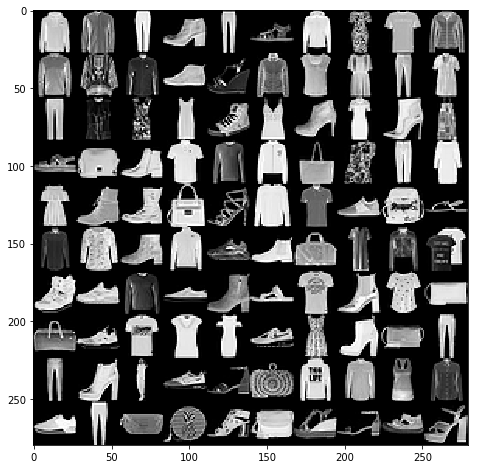

In [246]:
from MNIST_helper import plot_numbers, visualize_input
plot_numbers(x_train,range(100), columns=10, figsize=(8, 8))

# Regresion Logistica Multicapa

In [12]:
output_size = 10
default_initializer = initializers.normal(mean=0, stddev=0.001)
# default_initializer = 'normal'
# Creo el modelo
model_single_layer = Sequential()
model_single_layer.add(Flatten(input_shape=x_train.shape[1:]))
model_single_layer.add(Dense(output_size, kernel_initializer=default_initializer, name='Salida'))
model_single_layer.add(Activation('softmax'))
model_single_layer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
Salida (Dense)               (None, 10)                7850      
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Compilo el modelo
lr = 0.00001 #0.01, 0.001, 0.00001, 0.000001, 0.00000001
#lr = 0.00000001
#lr = 0.01
optim = optimizers.adam(lr=lr)
model_single_layer.compile(loss = 'categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

In [14]:
# Callbacks
## Callback para graficar
plot_losses = PlotLosses(plot_interval=1, evaluate_interval=20, x_val=x_valid, y_val_categorical=y_val_categorical)
## Callback para guardar pesos
checkpointer = ModelCheckpoint(filepath='single-layer.mnist.hdf5', verbose=1, save_best_only=True)

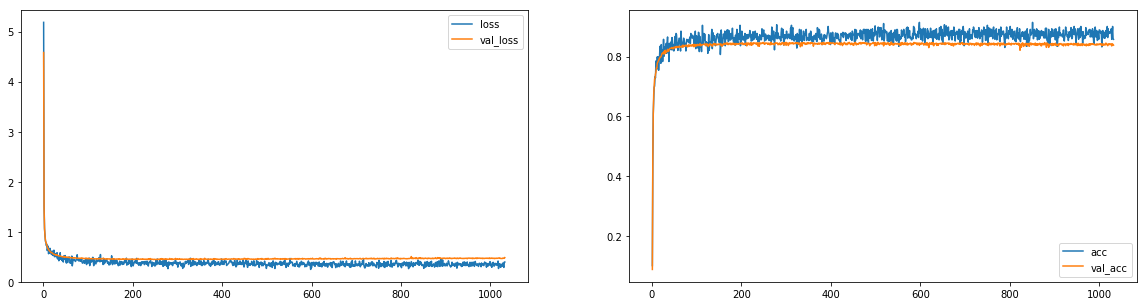


Epoch 00172: val_loss did not improve
Epoch 173/500
 9728/54000 [====>.........................] - ETA: 1s - loss: 0.3463 - acc: 0.8755

/Users/julianganzabal/anaconda3/envs/mllab/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151825). Check your callbacks.
  % delta_t_median)


KeyboardInterrupt: 

In [15]:
batch_size = 512
model_single_layer.fit(x_train, 
                       y_train_categorical,
                       epochs=500, batch_size=batch_size, 
                       verbose=1, 
                       validation_data = (x_valid, y_val_categorical),
                       callbacks=[plot_losses, checkpointer],
                      )

In [24]:
model_single_layer.load_weights('single-layer.mnist.hdf5')
model_single_layer.evaluate(x_valid, y_val_categorical)

6000/6000 [==============================] - 0s 32us/step


[0.45338038134574893, 0.84199999999999997]

# Red neuronal de 1 capa

In [39]:
def two_layer_model(lr=0.000001, decay=0):
    output_size = 10
    default_initializer = initializers.normal(mean=0, stddev=0.001)
    model = Sequential()
    model.add(Flatten(input_shape=x_train.shape[1:]))
    model.add(Dense(800, activation='sigmoid', kernel_initializer=default_initializer, name='middle'))
    model.add(Dense(output_size, activation='softmax', kernel_initializer='normal', name='Salida'))
    
    SGD = optimizers.Adam(lr=lr)
    model.compile(loss = 'categorical_crossentropy', optimizer=SGD, metrics=['accuracy'])
    return model
model_two_layers = two_layer_model()
model_two_layers.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 784)               0         
_________________________________________________________________
middle (Dense)               (None, 800)               628000    
_________________________________________________________________
Salida (Dense)               (None, 10)                8010      
Total params: 636,010
Trainable params: 636,010
Non-trainable params: 0
_________________________________________________________________


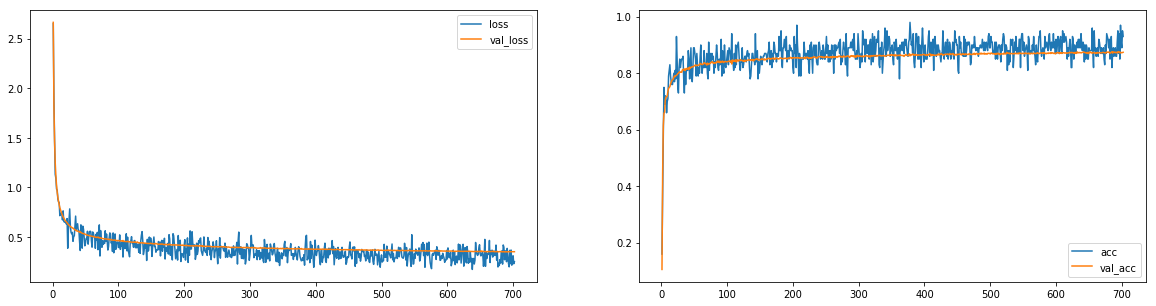

Epoch 27/100
  800/54000 [..............................] - ETA: 49s - loss: 0.3083 - acc: 0.8888 

/Users/julianganzabal/anaconda3/envs/mllab/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.572376). Check your callbacks.
  % delta_t_median)
/Users/julianganzabal/anaconda3/envs/mllab/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.286793). Check your callbacks.
  % delta_t_median)


10000/54000 [====>.........................] - ETA: 23s - loss: 0.2984 - acc: 0.8938

KeyboardInterrupt: 

In [43]:
plot_losses = PlotLosses(plot_interval=1, evaluate_interval=20, x_val=x_valid, y_val_categorical=y_val_categorical)
model_two_layers_2 = two_layer_model(lr=0.000001) # lr=0.000001, 
model_two_layers_2.fit(x_train, 
          y_train_categorical ,
          epochs=100, batch_size=100, 
          #verbose=1, 
          validation_data=(x_valid, y_val_categorical), 
          callbacks=[plot_losses],
         )

In [49]:
#model_two_layers_2.load_weights('single-layer.mnist.hdf5')
model_two_layers.evaluate(x_valid, y_val_categorical)

6000/6000 [==============================] - 1s 137us/step


[2.4801344846089681, 0.11266666666666666]

# Multicapa

In [236]:
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras import regularizers
from keras.constraints import max_norm
dropout_rate = 0.5
output_size = 10
max_norm_value = 10
initializer = initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
regul = regularizers.l2(0.000)
model = Sequential()
model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Dense(1024, kernel_regularizer = regul, 
                kernel_constraint = max_norm(max_norm_value),
                kernel_initializer=initializer, 
                name='middle1'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(256, kernel_regularizer = regul, 
                kernel_initializer=initializer, 
                kernel_constraint = max_norm(max_norm_value),
                name='middle2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(512, kernel_regularizer = regul, 
                kernel_initializer=initializer, 
                kernel_constraint = max_norm(max_norm_value),
                name='middle3'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))
#model.add(Dense(200, kernel_regularizer = regul, 
#                kernel_initializer=initializer, 
#                kernel_constraint = max_norm(max_norm_value),
#                name='middle4'))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(Dropout(dropout_rate))
model.add(Dense(output_size, activation='softmax', kernel_initializer=initializer, name='salida'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_56 (Flatten)         (None, 784)               0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 784)               3136      
_________________________________________________________________
middle1 (Dense)              (None, 1024)              803840    
_________________________________________________________________
batch_normalization_95 (Batc (None, 1024)              4096      
_________________________________________________________________
activation_87 (Activation)   (None, 1024)              0         
_________________________________________________________________
dropout_70 (Dropout)         (None, 1024)              0         
_________________________________________________________________
middle2 (Dense)              (None, 256)               262400    
__________

In [237]:
adam = optimizers.Adam(lr=0.005, decay=0.0001) #decay=1e-4
model.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

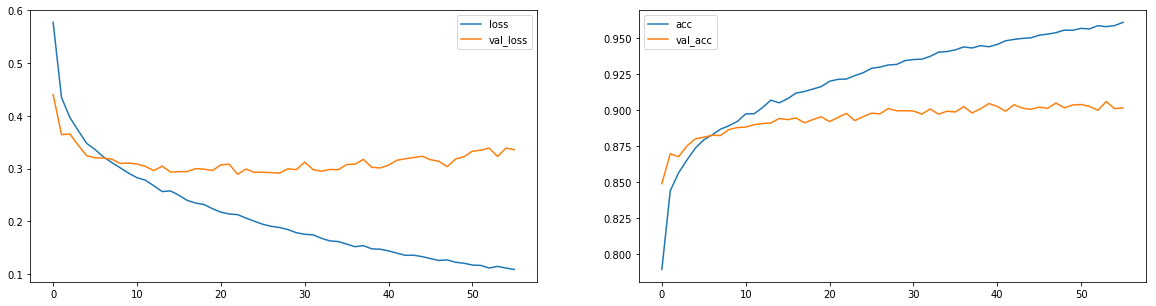


Epoch 00056: val_acc did not improve
Epoch 57/200
 4352/54000 [=>............................] - ETA: 33s - loss: 0.1029 - acc: 0.9625

KeyboardInterrupt: 

In [238]:
plot_losses = PlotLosses(plot_interval=1, evaluate_interval=None, x_val=x_valid, y_val_categorical=y_val_categorical)
checkpointer = ModelCheckpoint(filepath='5-layer.hdf5', monitor='val_acc', verbose=1, save_best_only=True)
model.fit(x_train, 
          y_train_categorical,
          epochs=200, batch_size=256, 
          #verbose=1, 
          validation_data=(x_valid, y_val_categorical), 
          callbacks=[plot_losses, checkpointer],
         )

In [239]:
model.evaluate(x_train, y_train_categorical)

54000/54000 [==============================] - 19s 354us/step


[0.048503340750311812, 0.98435185185185181]

In [240]:
#model_two_layers_2.load_weights('single-layer.mnist.hdf5')
model.evaluate(x_valid, y_val_categorical)

6000/6000 [==============================] - 2s 344us/step


[0.33849622155229253, 0.90133333333333332]

In [241]:
model.load_weights('5-layer.hdf5')
model.evaluate(x_valid, y_val_categorical)

6000/6000 [==============================] - 2s 340us/step


[0.32319350570937, 0.90583333333333338]

# Kaggle submit file

In [210]:
import pandas
def save_submit_file(x_test, model, filename):
    test_prediction = model.predict(x_test)
    test_labels = np.argmax(test_prediction, axis = 1)
    df = pandas.DataFrame(data={"Category": test_labels}).astype(int)
    df.to_csv(filename, sep=',',index=True,  index_label='Id')

In [242]:
save_submit_file(x_test, model, 'deep-mlp-dropout-BN-2.csv')

In [65]:
test_prediction = model.predict(x_test)

In [66]:
test_labels = np.argmax(test_prediction, axis = 1)

In [68]:
import pandas
df = pandas.DataFrame(data={"Category": test_labels}).astype(int)
df.to_csv("./submission_5.csv", sep=',',index=True,  index_label='Id')